# Carga de paquetes y conexión TPU

In [1]:
import numpy as np 
import pandas as pd 

import os
import tensorflow as tf
import random
from random import seed

import re
from kaggle_datasets import KaggleDatasets
from functools import partial

import math
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

In [2]:
# Siempre se va a intentar hacer 
# uso de las TPU si están disponibles
DEVICE = "TPU"

if DEVICE == "TPU":
    print("conectando a la TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print("Ejecutando en TPU: ", tpu.master())
    except ValueError:
        print("No se ha podido conectar a la TPU")
        tpu = None

    if tpu:
        try:
            print("Inicializando la  TPU ")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU inicializada")
        except _:
            print("Fallo al iniciar la TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Usando la estrategia por defecto de CPU/GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs disponibles: ", len(tf.config.experimental.list_physical_devices("GPU")))
    print("Lista de dispositivos:", tf.config.experimental.list_physical_devices("GPU"))

REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS:" +str(REPLICAS))

conectando a la TPU...
Ejecutando en TPU:  grpc://10.0.0.2:8470
Inicializando la  TPU 
TPU inicializada
REPLICAS:8


**Carga de variables**

In [3]:
## Variables

# Valor que establece el buffer_size 
# en operaciones como la de prefetch
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Path para la carga del dataset
GCS_PATH = KaggleDatasets().get_gcs_path("melanoma-512x512")

# Variables para la transformación de las imágenes
BATCH_SIZE = 256
IMAGE_SIZE = [512, 512]
IMG_SIZE   = 512
CROP_SIZE  = 480
FOLDS      = 15
NUM_AUG    = 7

# Número de tfrecords 
# a aumentar
TFRECORDS = 15

# Establecimiento de las semillas
SEED       = 1701
tf.random.set_seed(SEED)
seed(SEED)

# Funciones de tratamiento de imágenes y TFRecords

In [4]:
# Función que decodifica una imagen, la normaliza
# y la cambia a un tamaño apto para la red y el TPU
def decodeImage(image, augmentation):
    # Se decodifica la imagen con la librería tensorflow
    image = tf.image.decode_jpeg(image, channels=3)
    
    if augmentation:
        # Se recorta la imagen si hay dataAugmentation
        image = tf.image.random_crop(image,[CROP_SIZE,CROP_SIZE,3])
    
    # Normaliza la imagen convirtiendo los valores a un rango de [0,1]
    image = tf.cast(image, tf.float32)/ 255.0  
    
    # Se cambia el tamaño de la imagen
    image = tf.image.resize(image, [*IMAGE_SIZE])
    
    # Se cambia la forma de la imagen,
    # ya que es necesario para que tenga las dimensiones que espera la TPU
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    return image

# Función que establece como leer el tfrecord
# devolviendo la imagen y su etiqueta o
# la imagen o su nombre asociado
def readTfrecord(example, labeled, imageName, augmentation):
   
    
    if labeled:
        # Si viene del conjunto de train
        tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        })
        
        # Example tendrá dos elementos, imagen y label
        example = tf.io.parse_single_example(example, tfrecord_format) 
        
        # Se decodifica la imagen y se realiza el cast de la etiqueta
        image = decodeImage(example["image"],augmentation)
        label = tf.cast(example["target"], tf.int32)
        
        return image, label
    
    else:
        # Si viene del conjunto de test
        tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "image_name": tf.io.FixedLenFeature([], tf.string),
        })
        
        # Example tendrá dos elementos, imagen y nombre
        example = tf.io.parse_single_example(example, tfrecord_format)
        
        # Se decodifica la imagen
        image = decodeImage(example["image"],augmentation)
        return image, example["image_name"] if imageName else 0

    
# Función de data augmentation, preparada para aplicarse en
# una transformación map, 
# recibe la imagen a ser tratada y la clase

def dataAugmentation(image, label):
    # En la función 'getTrainingDataset()' se usará 'dataset.prefetch (AUTO)' lo que permitirá
    # que la CPU se encargue de la canalización de los datos mientras
    # que la TPU sólo realiza cálculo de gradientes aumentando la eficiencia

    if random.random() < .75:
        # Función que realiza un volteo aleatorio 
        # de izquierda/derecha sobre la imagen
        image = tf.image.random_flip_left_right(image)
    
    if random.random() < .75:
        # Función que realiza un volteo aleatorio
        # de arriba/abajo sobra la imagen
        image = tf.image.random_flip_up_down(image)

    if random.random() < .5:
        # Función que ajusta el brillo, el segundo valor
        # indica el rango máximo/mínimo
        image = tf.image.random_brightness(image, 0.2)

    if random.random() < .5:
        # Función que ajusta el tono de la imagen, el
        # segundo valor indica el rango máximo/mínimo
        image = tf.image.random_hue(image, 0.09, SEED)

    if random.random() < .5:
        # Funcion que ajusta la saturacion de la imagen,
        # indicando específicamente el mínimo y el máximo
        image = tf.image.random_saturation(image, 0.6, 1.4, SEED)

    if random.random() < .5:
        # Función que ajusta el contraste de la imagen,
        # indicando específicamente el mínimo y el máximo
        image = tf.image.random_contrast(image, 0.7, 1.3, SEED)

    if random.random() < .5:
        # Función que rota la imagen 90º de forma aleatoria
        image = tf.image.rot90(image, random.randint(0,3))
        
    if random.random() < .5:
        # Función que traspone la imagen
        image = tf.image.transpose(image)

    return image, label  

# Función que carga los tfrecords y los transforma en imagenes etiquetas/nombres
# pudiendo aplicar además data agumentation 
# y mezclado de los elementos
def loadDataset(filenames, labeled=True, imageName=False, shuffle=False, augmentation=False):
    
    # Se cargan los tfrecords en un dataset
    dataset = tf.data.TFRecordDataset(filenames)
    
    # Se extraen los elementos con la función 'readTfrecord'
    dataset = dataset.map(
        partial(readTfrecord, labeled=labeled,imageName=imageName,augmentation=augmentation), num_parallel_calls=AUTOTUNE)
    
    if augmentation:
        # Se aplica data agumentation
        dataset = dataset.map(dataAugmentation,num_parallel_calls=AUTOTUNE)
        
    if shuffle: 
        # Se mezclan los elementos
        dataset = dataset.shuffle(BATCH_SIZE * SEED)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        dataset = dataset.with_options(opt)
    
    
    return dataset

# Función que devuelve un dataset, que tras la carga de los tfrecords
# aplica distintas modificaciones como el prefetch o batch
def getDataset(filenames, labeled=True, imageName=False, repeat = False, shuffle=False, augmentation= False):
    
    # Se cargan los tfrecords
    dataset = loadDataset(filenames, labeled=labeled, imageName = imageName, shuffle=shuffle, augmentation=augmentation)
    
    # Se cachea el dataset
    dataset = dataset.cache()
    
    if repeat:
        # Se estable repetición infinita
        # para mejorar el rendimiento entre épocas
        dataset = dataset.repeat()
    
    # Esta función permite que la CPU se encargue de la canalización de los datos mientras
    # que la TPU sólo realiza cálculo de gradientes aumentando la eficiencia
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    # Se establece el tamaño del batch
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

# Función que devuelve el número de elementos en un tfrecord
# sin el coste computacional de contar los elementos
def countDataItems(filenames):
    # El número de elementos está escrito en el propio nombre del fichero .tfrec
    # Por ejemplo: test00-687.tfrec tiene 687 elementos
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Función que pinta imágenes contenidas 
# en un batch de un data set
def showImages(dataset):
    image_batch, label_batch = next(iter(dataset))
    
    plt.figure(figsize=(10, 10))
    for n in range(10):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] )
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")

In [5]:
# Funciones para transformar y escribir los datos
# en tfrecors
# https://www.tensorflow.org/tutorials/load_data/tfrecord
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(feature0, feature1):
    feature = {
        'image': _bytes_feature(feature0),
        'target': _int64_feature(feature1)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Visualización del dataset

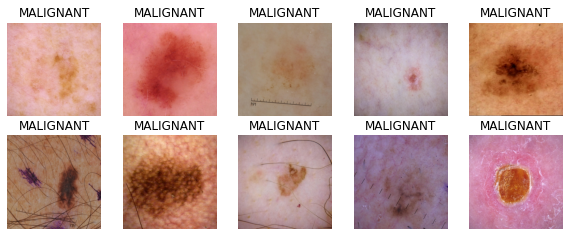

In [6]:
# Una muestra de imagenes sólo 
# con label igual a Maligno
FILENAMES = tf.io.gfile.glob(GCS_PATH + "/train00-2182.tfrec")
dsAll = getDataset(FILENAMES, labeled = True, 
                    imageName = False, repeat = False,
                    shuffle = False,augmentation = False)

dsAll = dsAll.unbatch()
dsMalig = dsAll.filter(lambda image,label: tf.equal(label, 1))


showImages(dsMalig.batch(BATCH_SIZE))

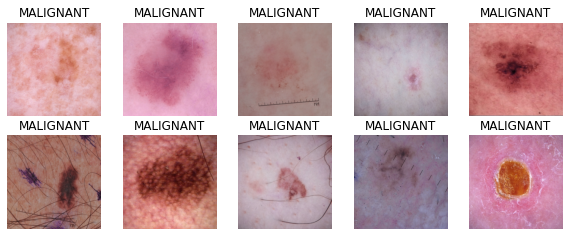

In [7]:
# Las mismas images después 
# del data augmentation
dsMaligAug = dsMalig.map(dataAugmentation)
showImages(dsMaligAug.batch(BATCH_SIZE))
    

# Creación de los nuevos TFRecords

In [8]:
for tfrecord in range(TFRECORDS):
    print("Se carga el tfrecord ["+str(tfrecord)+"]")
    FILENAMES = tf.io.gfile.glob(GCS_PATH + "/train%.2i-*.tfrec"%tfrecord)
    print(FILENAMES)
    
    # Se obtiene el dataset formado 
    # por un único tfrecord
    dsAll = getDataset(FILENAMES, labeled = True, 
                       imageName = False, repeat = False,
                       shuffle = False,augmentation = False)
    
    # Se aplica el unbatch para poder filtrar 
    # por valores malignos
    dsAll = dsAll.unbatch()
    dsMalig = dsAll.filter(lambda image,label: tf.equal(label, 1))
    
    # Se crean las variables para poder 
    # construir el fichero
    listTmp = list()
    numFicheros = 0
    
    # Número de veces que se aplica 
    # el dataAugmentation
    for aug in range(NUM_AUG):
        # Se aplica la función dataAugmentation
        dsMaligAug = dsMalig.map(dataAugmentation)
        
        # Se convierte en iterador 
        # y se añade a la lista
        tmp = dsMaligAug.as_numpy_iterator()
        listTmp.append(tmp)
        
        # Sólo se calcula el número de ficheros 
        # en el tfrecord una vez, ya que es una operación 
        # de alto coste computacional
        if numFicheros == 0:
            numFicheros = len(list(tmp))
            print("NumFicheros en el tfrecord ["+str(numFicheros)+"]")

    # Se itera sobre los elementos para escribir 
    # cada tupla de imagen/etiqueta
    # El número de elementos se calcula con el valor anterior
    # y el número de veces que se aplica el dataAugmentation
    with tf.io.TFRecordWriter("aug%.2i-%i.tfrec"%(tfrecord,numFicheros*NUM_AUG)) as writer:
        for iterator in listTmp:
            for image,label in iterator:
                    example = serialize_example(tf.image.encode_jpeg(image * 255.0  ),label)
                    writer.write(example)

Se carga el tfrecord [0]
['gs://kds-dadafc03331a1bac248a916a3b291249d5b9decf387d0617b8b7958c/train00-2182.tfrec']
NumFicheros en el tfrecord [38]
Se carga el tfrecord [1]
['gs://kds-dadafc03331a1bac248a916a3b291249d5b9decf387d0617b8b7958c/train01-2185.tfrec']
NumFicheros en el tfrecord [38]
Se carga el tfrecord [2]
['gs://kds-dadafc03331a1bac248a916a3b291249d5b9decf387d0617b8b7958c/train02-2193.tfrec']
NumFicheros en el tfrecord [39]
Se carga el tfrecord [3]
['gs://kds-dadafc03331a1bac248a916a3b291249d5b9decf387d0617b8b7958c/train03-2182.tfrec']
NumFicheros en el tfrecord [40]
Se carga el tfrecord [4]
['gs://kds-dadafc03331a1bac248a916a3b291249d5b9decf387d0617b8b7958c/train04-2167.tfrec']
NumFicheros en el tfrecord [38]
Se carga el tfrecord [5]
['gs://kds-dadafc03331a1bac248a916a3b291249d5b9decf387d0617b8b7958c/train05-2171.tfrec']
NumFicheros en el tfrecord [38]
Se carga el tfrecord [6]
['gs://kds-dadafc03331a1bac248a916a3b291249d5b9decf387d0617b8b7958c/train06-2175.tfrec']
NumFichero